In [9]:
%load_ext autoreload
%autoreload 2 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import torch
from sqnet import SQNet
import numpy as np
from utils import solve_crocoddyl, random_array, griddata
from data import solver_norms
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
net = torch.load('valuenet.pth')

In [12]:
xtest = griddata(70)
print(xtest.shape)

(4900, 3)


In [13]:
def network_norms(net, xtest):
    cost = net(torch.tensor(xtest, dtype=torch.float32)).detach().numpy().reshape(-1,1)
    
    true_gradient      = []
    approx_hessian     = []
    true_hessian       = []

    states = torch.tensor(xtest, dtype=torch.float32)
    
    for state in states:
        
        state = state.reshape(1, 3)
        
        # True gradient
        grad = net.jacobian(state)
        true_gradient.append(np.linalg.norm(grad.detach().numpy()))
        #print(grad)
        
        # True Hessian
        _hessian = net.hessian(state)
        true_hessian.append(np.linalg.norm(_hessian))
        #print(_hessian)
        
        # Estimating from Jacobian
        newton = grad.T @ grad
        newton_hessian = newton.detach().numpy()
        approx_hessian.append(np.linalg.norm(newton_hessian))

        
    true_gradient    =  np.array(true_gradient).reshape(-1, 1)
    true_hessian     =  np.array(true_hessian).reshape(-1,1)
    approx_hessian   =  np.array(approx_hessian).reshape(-1, 1)
    
    return cost, true_gradient, true_hessian, approx_hessian

In [14]:
cost_pred, net_gradient, net_hessian, net_approx_hessian = network_norms(net, xtest)


In [15]:
cost, vx, vxx = solver_norms(xtest)

Text(0.5, 1.0, 'norm Vxx')

<Figure size 432x288 with 0 Axes>

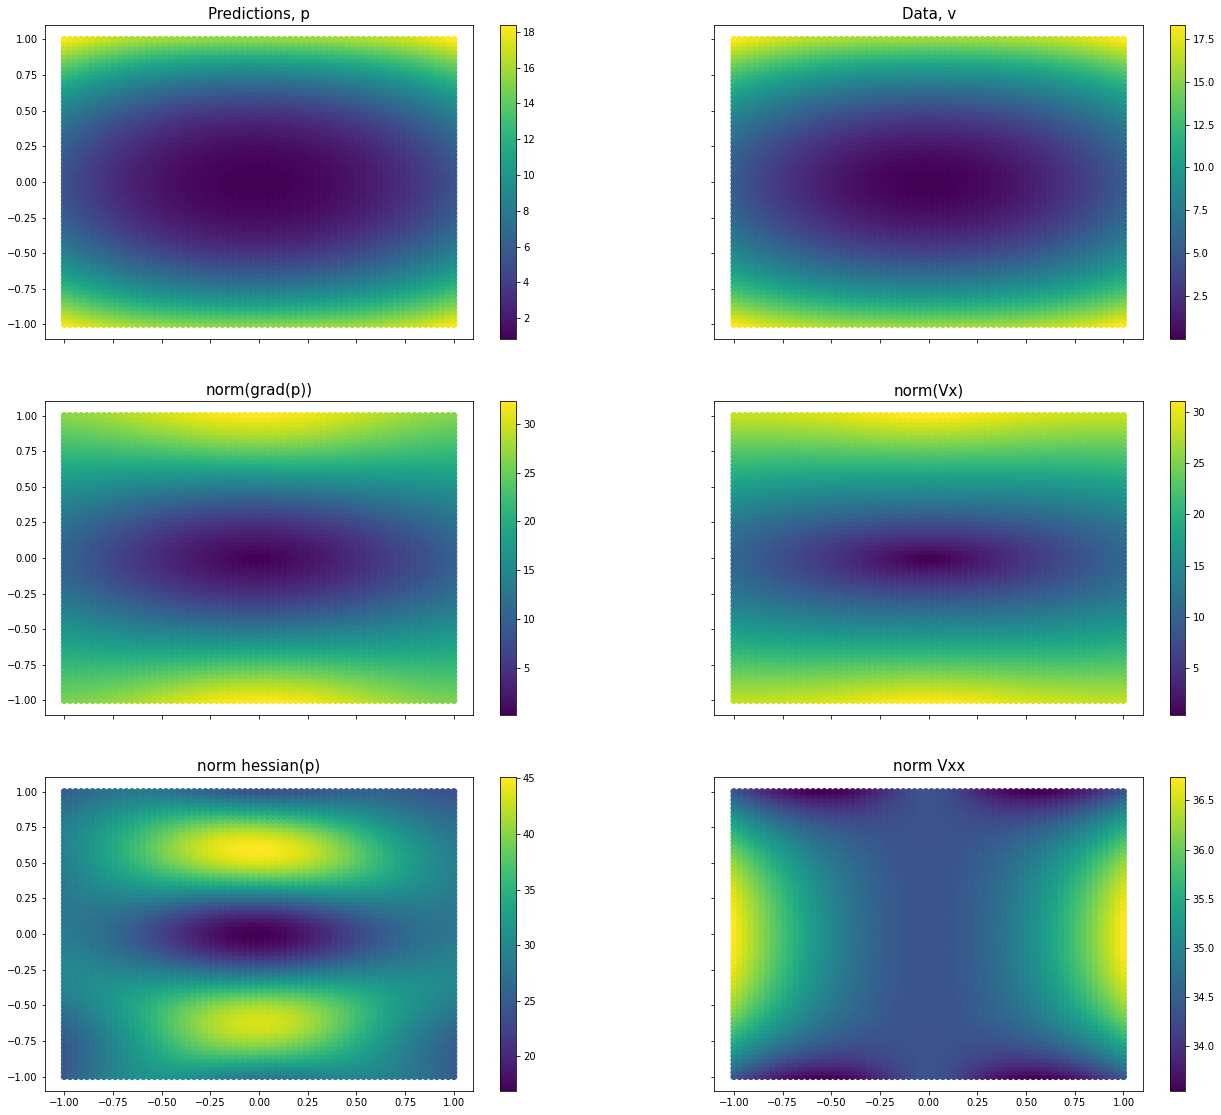

In [16]:
plt.clf()

# Make the figure:

fig, axs = plt.subplots(3, 2, figsize=(18, 20), sharex=True, sharey ='row')
fig.subplots_adjust(left=0.02, bottom=0.2, right=0.95, top=0.94, wspace=0.25)

# Plot prediction, cost
im1 = axs[0, 0].scatter(x = xtest[:,0], y = xtest[:,1], c= cost_pred)
fig.colorbar(im1, ax=axs[0, 0])


im2 = axs[0, 1].scatter(x = xtest[:,0], y = xtest[:,1], c= cost)
fig.colorbar(im2, ax=axs[0, 1])



im3 = axs[1, 0].scatter(x = xtest[:,0], y = xtest[:,1], c=  net_gradient)
fig.colorbar(im3, ax=axs[1, 0])

im4 = axs[1, 1].scatter(x = xtest[:,0], y = xtest[:,1], c=  vx)
fig.colorbar(im4, ax=axs[1, 1])


im5 = axs[2, 0].scatter(x = xtest[:,0], y = xtest[:,1], c=  net_hessian)
fig.colorbar(im5, ax=axs[2, 0])

im6 = axs[2, 1].scatter(x = xtest[:,0], y = xtest[:,1], c=  vxx)
fig.colorbar(im6, ax=axs[2, 1])




# Set titles
axs[0, 0].set_title("Predictions, p", fontsize  = 15)
axs[0, 1].set_title("Data, v", fontsize  = 15)

axs[1, 0].set_title("norm(grad(p))", fontsize  = 15)
axs[1, 1].set_title("norm(Vx)", fontsize  = 15)
axs[2, 0].set_title("norm hessian(p)", fontsize  = 15)
axs[2, 1].set_title("norm Vxx", fontsize  = 15)
